In [2]:
import rpy2.robjects as robjects
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
%matplotlib inline

In [3]:
robjects.r['load']("mri.RData")

R object with classes: ('character',) mapped to:
<StrVector - Python:0x7fcbc8c92368 / R:0x2c978e8>
[str]

In [4]:
pos = np.array(robjects.r['output'][5])
pval = np.array(robjects.r['output'][2])
cat = np.array(robjects.r['output'][4])

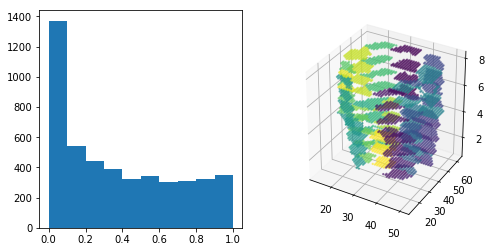

In [6]:
fig = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.hist(pval,10)
ax = fig.add_subplot(122, projection='3d')
ax.scatter(pos[:,0], pos[:,1], pos[:,2], c=cat, s=2, alpha = 0.5)
plt.savefig('mri.png')

In [66]:
def BH(x, alpha = 0.05):
    x_s = sorted(x)
    n = len(x_s)
    ic = 0
    for i in range(n):
        if x_s[i] < i*alpha/float(n):
            ic = i
    return ic, x_s[ic]

In [219]:
res = BH(pval, alpha = 0.2)
pBH = res[1][0]
print pBH

0.0394207946116


In [220]:
num_samples = len(pval)

In [404]:
network = nn.Sequential(
        nn.Linear(3,20),
        nn.LeakyReLU(0.1),
        nn.Linear(20,20),
        nn.LeakyReLU(0.1),
        nn.Linear(20,20),
        nn.LeakyReLU(0.1),
        nn.Linear(20,20),
        nn.LeakyReLU(0.1),
        nn.Linear(20,10),
        nn.LeakyReLU(0.1),
        nn.Linear(10,10),
        nn.LeakyReLU(0.1),
        nn.Linear(10,1),
        nn.Sigmoid()
)

soft_compare = nn.Sigmoid()
optimizer = optim.Adagrad(network.parameters(), lr = 0.01)
l1loss = nn.L1Loss()

In [405]:
for item in network.parameters():
    item.data.uniform_(-0.05, 0.05)

In [406]:
target = Variable(torch.from_numpy(pBH * np.ones((num_samples, 1)).astype(np.float32).reshape(num_samples,1)))

In [407]:
loss_hist = []
for iteration in range(10000):
        
    x_input = Variable(torch.from_numpy(pos.astype(np.float32).reshape(num_samples,3)))
    
    optimizer.zero_grad()
    output = network.forward(x_input) * 0.2
    
    loss = l1loss(output, target)
    
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.data[0])

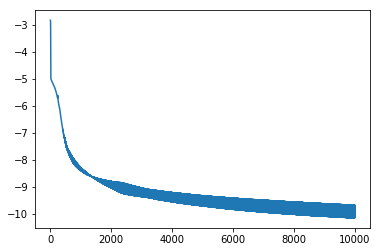

In [408]:
plt.plot(np.log(loss_hist))

In [431]:
loss_hist = []
for iteration in range(10000):
    if iteration % 100 == 0:
        print iteration, s.data[0], (s2/s).data[0]
    
    x_input = Variable(torch.from_numpy(pos.astype(np.float32).reshape(num_samples,3)))
    p_input = Variable(torch.from_numpy(pval.astype(np.float32).reshape(num_samples,1)))
    
    optimizer.zero_grad()
    output = network.forward(x_input) * 0.2
    s = torch.sum(soft_compare((output - p_input) * 1e2)) / num_samples
    s2 = torch.sum(soft_compare((p_input - (1-output)) * 1e2)) / num_samples
    
    gain = s  - 2 * soft_compare((s2 - s*0.2) * 1e4) 
    
    loss = -gain
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.data[0])

0 0.254561364651 0.196805939078
100 0.254582226276 0.196815758944
200 0.254588067532 0.196813777089
300 0.254602700472 0.196822568774
400 0.254607588053 0.196822211146
500 0.254609167576 0.196819186211
600 0.254613906145 0.196818679571
700 0.254615515471 0.196815505624
800 0.254624038935 0.196818709373
900 0.254632979631 0.196822464466
1000 0.254636883736 0.196821093559
1100 0.254637897015 0.196817308664
1200 0.254645347595 0.196819514036
1300 0.254648685455 0.196818098426
1400 0.25465759635 0.196821376681
1500 0.254660785198 0.196819618344
1600 0.254663676023 0.196817696095
1700 0.254671394825 0.196820557117
1800 0.254671096802 0.196815520525
1900 0.254685401917 0.196824297309
2000 0.25469020009 0.196824222803
2100 0.254696547985 0.196825549006
2200 0.25469148159 0.196816548705
2300 0.254693984985 0.196814596653
2400 0.254707098007 0.19682238996
2500 0.254701077938 0.19681237638
2600 0.254704535007 0.196811243892
2700 0.254707098007 0.196809396148
2800 0.254715532064 0.19681276381
290

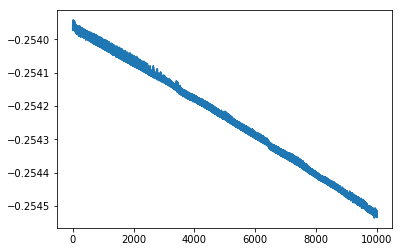

In [432]:
plt.plot(loss_hist)

In [433]:
x_input = Variable(torch.from_numpy(pos.astype(np.float32).reshape(num_samples ,3)))
p_input = Variable(torch.from_numpy(pval.astype(np.float32).reshape(num_samples ,1)))

output = network.forward(x_input) * 0.2
pred = (p_input < output).data.numpy()
pred = pred[:,0].astype(np.float32)

In [434]:
sum(pred)

1205.0